In [1]:
import glob
from typing import List

import BiT
from ViT import modeling as ViT

from PIL import Image
from PIL.Image import Image as Img
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle

import numpy as np

import torch.nn as nn
import torch
import torchvision.transforms as T

from ipynb.fs.full.perturb_dataset import *

In [2]:
DATASET_PATH = 'data/cats'

IMG_SIZE = (384, 384)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
TRANSFORMS = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])

In [3]:
def load_images(dataset_path: str) -> List[Img]:
    images = []
    for filename in glob.glob(dataset_path + '/*.jpg'):
        im=Image.open(filename).convert('RGB')
        images.append(im)
    return images


def load_vit(model_name='ViT-B_16', path='ViT-B_16.npz') -> nn.Module:
    config = ViT.CONFIGS[model_name]
    model = ViT.VisionTransformer(config, num_classes=1000, img_size=384)
    model.load_from(np.load(path))
    return model.eval()

def load_bit(model_name='BiT-M-R50x3', path='BiT-M-R50x3-ILSVRC2012.npz') -> nn.Module:
    model = BiT.KNOWN_MODELS[model_name](head_size=1000)
    model.load_from(np.load(path))
    return model

In [4]:
images = load_images(DATASET_PATH)
VIT = load_vit()
BIT = load_bit()

In [5]:
import gc

LABELS = list(open('ilsvrc2012_wordnet_lemmas.txt').read().split("\n"))

def predict(model, inputs: List[Img], top_k: int = 5) -> List[List[str]]:
    """Return top_k labels for each inpuuts image."""
    imgs = torch.cat([
        TRANSFORMS(input).unsqueeze(0)
        for input in inputs
    ])
    out = model(imgs)
    if isinstance(out, tuple):
        out = out[0]
    out = out.detach().numpy()
    
    predictions = []
    for idx in range(len(out)):
        values = [(v, i) for i, v in enumerate(out[idx])]
        values.sort(reverse=True)
        predictions.append([LABELS[i] for _, i in values[:top_k]])
    gc.collect()

    return predictions
    
def predict_batch(model, inputs, batch_size: int, **kwargs):
    predictions = []
    for i in range(0, len(inputs), batch_size):
        batch = inputs[i: i+batch_size]
        predictions.extend(predict(model, batch, **kwargs))
    return predictions


## Cat classifing function

In [6]:
def is_cat(labels, top_k=1):
    return bool(set(labels[:top_k]) & {
        "tabby, tabby_cat",
        "tiger_cat",
        "Persian_cat",
        "Siamese_cat, Siamese",
        "Egyptian_cat"
    })

# Assert cats

Check for pictures which are not classified as cats

In [22]:
# vit_not_cats = [
#     i 
#     for i in range(len(images))
#     if not is_cat(predict(VIT, [images[i]])[0])
# ]

In [7]:
vit_not_cats = [2, 11, 14, 20, 26, 27, 37, 39, 46, 59, 60, 73, 91, 94, 96, 98, 99, 102, 107, 108, 120, 122, 133, 138, 150, 153, 154, 159, 160, 161, 163, 165, 169, 191, 194, 199, 206]

In [24]:
# bit_not_cats = [
#     i 
#     for i in range(len(images))
#     if not is_cat(predict(BIT, [images[i]])[0])
# ]

In [8]:
bit_not_cats = [3, 14, 20, 21, 26, 27, 30, 39, 48, 53, 57, 59, 79, 81, 94, 95, 96, 98, 99, 107, 114, 130, 133, 136, 142, 150, 153, 155, 158, 160, 163, 165, 199, 207]

In [9]:
# Images classified by both models as cats
both_cats = [
    i
    for i in range(len(images))
    if (i not in bit_not_cats) and (i not in vit_not_cats)
]
# both_cats

## Hard examples for both models
Check images which are not cat at `top_1`, if are cat at `top_5`

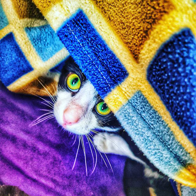

VIT: True ['bath_towel', 'tabby, tabby_cat', 'Egyptian_cat', 'quilt, comforter, comfort, puff', 'shower_curtain']
BIT: True ['bath_towel', 'tabby, tabby_cat', 'tiger_cat', 'doormat, welcome_mat', 'Egyptian_cat']


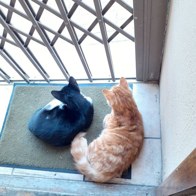

VIT: True ['doormat, welcome_mat', 'Egyptian_cat', 'Cardigan, Cardigan_Welsh_corgi', 'tiger_cat', 'tabby, tabby_cat']
BIT: False ['doormat, welcome_mat', 'schipperke', 'Pembroke, Pembroke_Welsh_corgi', 'Cardigan, Cardigan_Welsh_corgi', 'basenji']


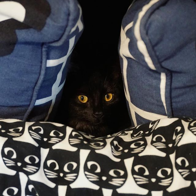

VIT: True ['sleeping_bag', 'quilt, comforter, comfort, puff', 'Egyptian_cat', 'ski_mask', 'backpack, back_pack, knapsack, packsack, rucksack, haversack']
BIT: True ['sleeping_bag', 'Egyptian_cat', 'Persian_cat', 'velvet', 'quilt, comforter, comfort, puff']


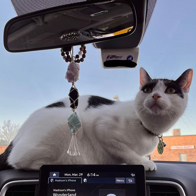

VIT: True ['car_mirror', 'radio, wireless', 'Egyptian_cat', 'iPod', 'tabby, tabby_cat']
BIT: True ['car_mirror', 'Egyptian_cat', 'Siamese_cat, Siamese', 'hook, claw', 'balloon']


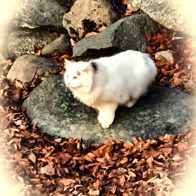

VIT: True ['Arctic_fox, white_fox, Alopex_lagopus', 'Persian_cat', 'Egyptian_cat', 'tiger_cat', 'lynx, catamount']
BIT: True ['Arctic_fox, white_fox, Alopex_lagopus', 'Persian_cat', 'Samoyed, Samoyede', 'red_fox, Vulpes_vulpes', 'grey_fox, gray_fox, Urocyon_cinereoargenteus']


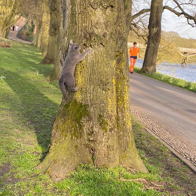

VIT: False ['fox_squirrel, eastern_fox_squirrel, Sciurus_niger', 'mink', 'beaver', 'weasel', 'acorn']
BIT: False ['weasel', 'otter', 'mongoose', 'mink', 'meerkat, mierkat']


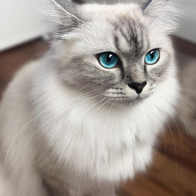

VIT: True ['lynx, catamount', 'Siamese_cat, Siamese', 'tabby, tabby_cat', 'Egyptian_cat', 'Persian_cat']
BIT: True ['lynx, catamount', 'Egyptian_cat', 'tabby, tabby_cat', 'Persian_cat', 'Siamese_cat, Siamese']


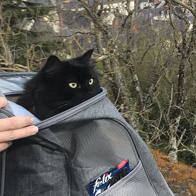

VIT: True ['backpack, back_pack, knapsack, packsack, rucksack, haversack', 'mailbag, postbag', 'hamper', 'Egyptian_cat', 'tabby, tabby_cat']
BIT: True ['backpack, back_pack, knapsack, packsack, rucksack, haversack', 'plastic_bag', 'Egyptian_cat', 'hamper', 'ashcan, trash_can, garbage_can, wastebin, ash_bin, ash-bin, ashbin, dustbin, trash_barrel, trash_bin']


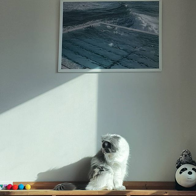

VIT: True ['desk', 'Persian_cat', 'Lhasa, Lhasa_apso', 'Pekinese, Pekingese, Peke', 'Shih-Tzu']
BIT: True ['television, television_system', 'Persian_cat', 'window_screen', 'pool_table, billiard_table, snooker_table', 'window_shade']


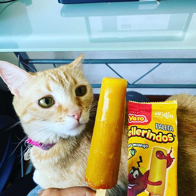

VIT: True ['ice_lolly, lolly, lollipop, popsicle', 'Egyptian_cat', 'candle, taper, wax_light', 'hotdog, hot_dog, red_hot', 'ear, spike, capitulum']
BIT: False ['ice_lolly, lolly, lollipop, popsicle', 'packet', 'ear, spike, capitulum', 'hotdog, hot_dog, red_hot', 'confectionery, confectionary, candy_store']


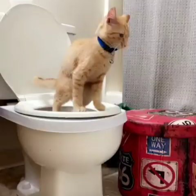

VIT: False ['toilet_seat', 'toilet_tissue, toilet_paper, bathroom_tissue', 'shower_curtain', "plunger, plumber's_helper", 'paper_towel']
BIT: True ['toilet_seat', 'Egyptian_cat', 'toilet_tissue, toilet_paper, bathroom_tissue', 'tiger_cat', 'tabby, tabby_cat']


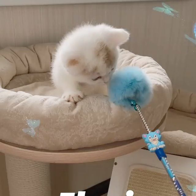

VIT: True ['Angora, Angora_rabbit', 'Egyptian_cat', 'Persian_cat', 'Samoyed, Samoyede', 'Arctic_fox, white_fox, Alopex_lagopus']
BIT: True ['Angora, Angora_rabbit', 'Samoyed, Samoyede', 'Persian_cat', 'hair_slide', 'Egyptian_cat']


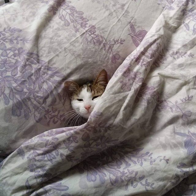

VIT: True ['quilt, comforter, comfort, puff', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'sleeping_bag']
BIT: True ['quilt, comforter, comfort, puff', 'tiger_cat', 'tabby, tabby_cat', 'Egyptian_cat', 'velvet']


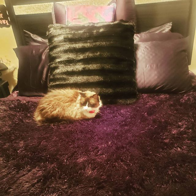

VIT: True ['weasel', 'black-footed_ferret, ferret, Mustela_nigripes', 'polecat, fitch, foulmart, foumart, Mustela_putorius', 'Siamese_cat, Siamese', 'Egyptian_cat']
BIT: False ['velvet', 'studio_couch, day_bed', 'quilt, comforter, comfort, puff', 'prayer_rug, prayer_mat', 'wool, woolen, woollen']


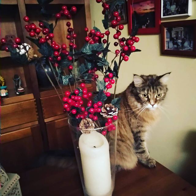

VIT: True ['candle, taper, wax_light', 'tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'vase']
BIT: True ['candle, taper, wax_light', 'vase', 'tabby, tabby_cat', 'Egyptian_cat', 'tiger_cat']


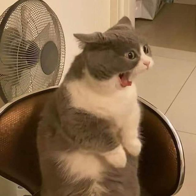

VIT: True ['electric_fan, blower', 'Egyptian_cat', 'tiger_cat', 'tabby, tabby_cat', 'Persian_cat']
BIT: True ['electric_fan, blower', 'Egyptian_cat', 'tiger_cat', 'tabby, tabby_cat', 'Persian_cat']


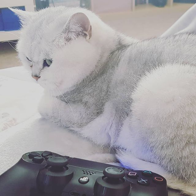

VIT: True ['mouse, computer_mouse', 'tiger_cat', 'Egyptian_cat', 'remote_control, remote', 'computer_keyboard, keypad']
BIT: True ['joystick', 'Egyptian_cat', 'remote_control, remote', 'mouse, computer_mouse', 'lynx, catamount']


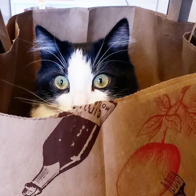

VIT: True ['plastic_bag', 'carton', 'Egyptian_cat', 'tabby, tabby_cat', 'Persian_cat']
BIT: True ['carton', 'tabby, tabby_cat', 'mailbag, postbag', 'plastic_bag', 'Egyptian_cat']


In [10]:
for idx in (set(vit_not_cats) & set(bit_not_cats)):
    display(images[idx].resize((196, 196)))
    
    vit_labels = predict(VIT, [images[idx]])[0]
    print("VIT:", is_cat(vit_labels, 5), vit_labels)
    
    bit_labels = predict(BIT, [images[idx]])[0]
    print("BIT:", is_cat(bit_labels, 5), bit_labels)

# Compare models fails
Mask random cat picture and check if it is still classified as cat.


In [22]:
from IPython.display import display
import random
from collections import Counter


def test_masking(func, total):
    vit_fails, bit_fails = Counter(), Counter()
    for i in range(total):
        idx = random.choice(both_cats)
        img = func(images[idx])

        labels_vit = predict(VIT, [img])[0]
        labels_bit = predict(BIT, [img])[0]

        if not is_cat(labels_vit):
            vit_fails[labels_vit[0]] += 1
        if not is_cat(labels_bit):
            bit_fails[labels_bit[0]] += 1

        if not is_cat(labels_vit) or not is_cat(labels_bit):
            display(img.resize((196, 196)))

            print("VIT:", is_cat(labels_vit, 5), labels_vit)
            print("BIT:", is_cat(labels_bit, 5), labels_bit)

    print(f"VIT: {total - sum(vit_fails.values())}; BIT: {total - sum(bit_fails.values())}", "\n")
    print(vit_fails)
    print(bit_fails)

## Test BlackBoxMasking

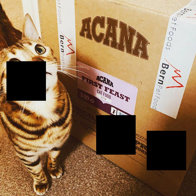

VIT: True ['carton', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'crate']
BIT: True ['tiger_cat', 'tabby, tabby_cat', 'carton', 'Egyptian_cat', 'tiger, Panthera_tigris']


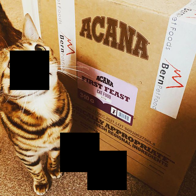

VIT: True ['carton', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'crate']
BIT: True ['tiger_cat', 'tabby, tabby_cat', 'carton', 'tiger, Panthera_tigris', 'Egyptian_cat']


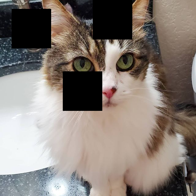

VIT: True ['toilet_tissue, toilet_paper, bathroom_tissue', 'paper_towel', 'toilet_seat', 'Egyptian_cat', 'tabby, tabby_cat']
BIT: True ['tabby, tabby_cat', 'Egyptian_cat', 'tiger_cat', 'washbasin, handbasin, washbowl, lavabo, wash-hand_basin', 'tub, vat']


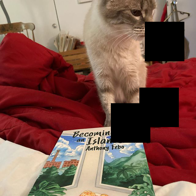

VIT: True ['Egyptian_cat', 'tabby, tabby_cat', 'Siamese_cat, Siamese', 'tiger_cat', 'lynx, catamount']
BIT: True ['lynx, catamount', 'Siamese_cat, Siamese', 'Egyptian_cat', 'comic_book', 'tiger_cat']


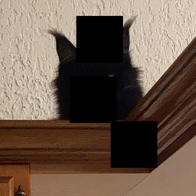

VIT: True ['Egyptian_cat', 'schipperke', 'groenendael', 'Scotch_terrier, Scottish_terrier, Scottie', 'tabby, tabby_cat']
BIT: True ['schipperke', 'groenendael', 'Scotch_terrier, Scottish_terrier, Scottie', 'giant_schnauzer', 'Egyptian_cat']


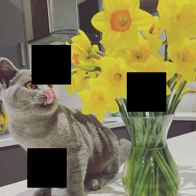

VIT: True ['tabby, tabby_cat', 'Egyptian_cat', 'tiger_cat', 'vase', 'pot, flowerpot']
BIT: True ['vase', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'pot, flowerpot']
VIT: 29; BIT: 29
Counter({'carton': 2, 'toilet_tissue, toilet_paper, bathroom_tissue': 1})
Counter({'lynx, catamount': 1, 'schipperke': 1, 'vase': 1})


In [15]:
test_masking(
    BlackBoxMasking(layout=FixedShapeLayout(count=3, shape=(128, 128))),
    32
)

## Blur Masking

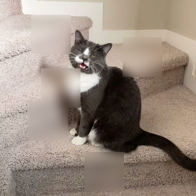

VIT: True ['Egyptian_cat', 'tiger_cat', 'tabby, tabby_cat', 'space_heater', 'radiator']
BIT: True ['paper_towel', 'toilet_tissue, toilet_paper, bathroom_tissue', 'Egyptian_cat', 'tabby, tabby_cat', 'doormat, welcome_mat']


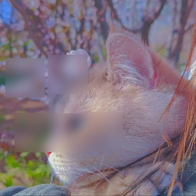

VIT: True ['Persian_cat', 'Angora, Angora_rabbit', 'Egyptian_cat', 'Siamese_cat, Siamese', 'lynx, catamount']
BIT: True ['hamster', 'tiger_cat', 'tabby, tabby_cat', 'Angora, Angora_rabbit', 'television, television_system']


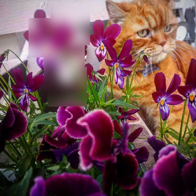

VIT: True ['picket_fence, paling', 'tabby, tabby_cat', 'tiger_cat', 'pot, flowerpot', 'Persian_cat']
BIT: True ['tiger_cat', 'tabby, tabby_cat', 'Egyptian_cat', 'pot, flowerpot', 'bee']


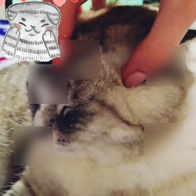

VIT: True ['Angora, Angora_rabbit', 'Norwegian_elkhound, elkhound', 'Egyptian_cat', 'Siberian_husky', 'Siamese_cat, Siamese']
BIT: True ['Persian_cat', 'Siamese_cat, Siamese', 'polecat, fitch, foulmart, foumart, Mustela_putorius', 'Angora, Angora_rabbit', 'keeshond']


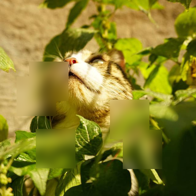

VIT: True ['fig', 'tabby, tabby_cat', 'Granny_Smith', 'Egyptian_cat', 'titi, titi_monkey']
BIT: True ['tiger_cat', 'polecat, fitch, foulmart, foumart, Mustela_putorius', 'meerkat, mierkat', 'Egyptian_cat', 'tabby, tabby_cat']


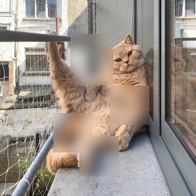

VIT: True ['tabby, tabby_cat', 'window_screen', 'tiger_cat', 'Egyptian_cat', 'Persian_cat']
BIT: True ['window_screen', 'Egyptian_cat', 'Persian_cat', 'tiger_cat', 'lynx, catamount']
VIT: 29; BIT: 29
Counter({'picket_fence, paling': 1, 'Angora, Angora_rabbit': 1, 'fig': 1})
Counter({'paper_towel': 1, 'hamster': 1, 'window_screen': 1})


In [16]:
test_masking(
    BlurMasking(layout=FixedShapeLayout(count=5, shape=(128, 128))),
    32
)

## BlackBoxMasking with FixedRatioLayout

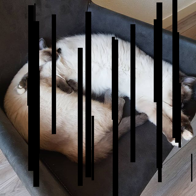

VIT: True ['Siamese_cat, Siamese', 'Egyptian_cat', 'lynx, catamount', 'radiator', 'bathtub, bathing_tub, bath, tub']
BIT: False ['bannister, banister, balustrade, balusters, handrail', 'prison, prison_house', 'sliding_door', 'four-poster', 'shoji']


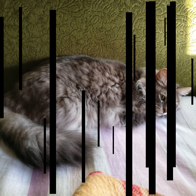

VIT: True ['tabby, tabby_cat', 'Persian_cat', 'Egyptian_cat', 'tiger_cat', 'chime, bell, gong']
BIT: True ['prison, prison_house', 'pole', 'tiger_cat', 'shoji', 'macaque']


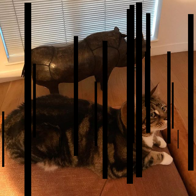

VIT: True ['tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'prison, prison_house', 'fire_screen, fireguard']
BIT: True ['pole', 'space_heater', 'radiator', 'tiger_cat', 'fire_screen, fireguard']


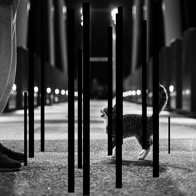

VIT: False ['toy_poodle', 'miniature_poodle', 'Irish_water_spaniel', 'pole', 'standard_poodle']
BIT: False ['pole', 'sliding_door', 'prison, prison_house', 'parallel_bars, bars', 'bannister, banister, balustrade, balusters, handrail']


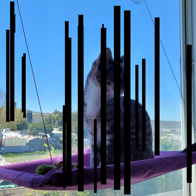

VIT: True ['chime, bell, gong', 'Egyptian_cat', 'gong, tam-tam', 'tabby, tabby_cat', 'Siamese_cat, Siamese']
BIT: False ['pole', 'sliding_door', 'horizontal_bar, high_bar', 'window_screen', 'parallel_bars, bars']


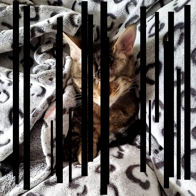

VIT: True ['Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'prison, prison_house', 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence']
BIT: True ['prison, prison_house', 'tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'tiger, Panthera_tigris']


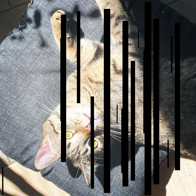

VIT: True ['tiger_cat', 'tabby, tabby_cat', 'Egyptian_cat', 'pole', 'radiator']
BIT: True ['prison, prison_house', 'bannister, banister, balustrade, balusters, handrail', 'tabby, tabby_cat', 'shoji', 'tiger_cat']


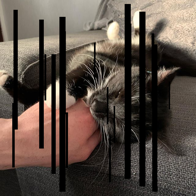

VIT: True ['Siamese_cat, Siamese', 'chime, bell, gong', 'drumstick', 'Persian_cat', 'tabby, tabby_cat']
BIT: True ['prison, prison_house', 'tiger_cat', 'turnstile', 'tabby, tabby_cat', 'Egyptian_cat']


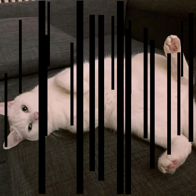

VIT: True ['Egyptian_cat', 'Angora, Angora_rabbit', 'window_screen', 'chime, bell, gong', 'window_shade']
BIT: False ['prison, prison_house', 'crib, cot', 'shoji', 'bannister, banister, balustrade, balusters, handrail', 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence']


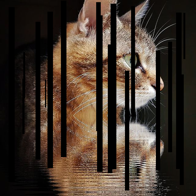

VIT: True ['tiger_cat', 'tabby, tabby_cat', 'Egyptian_cat', 'lynx, catamount', 'Persian_cat']
BIT: True ['prison, prison_house', 'tabby, tabby_cat', 'Egyptian_cat', 'tiger_cat', 'sliding_door']


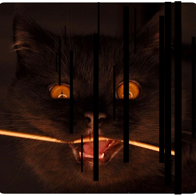

VIT: True ['Persian_cat', 'Egyptian_cat', 'Siamese_cat, Siamese', 'tabby, tabby_cat', 'chime, bell, gong']
BIT: True ['prison, prison_house', 'shoji', 'Persian_cat', 'window_screen', 'fire_screen, fireguard']


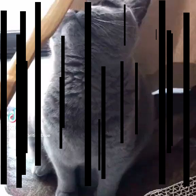

VIT: True ['Egyptian_cat', 'tiger_cat', 'tabby, tabby_cat', 'Persian_cat', 'Siamese_cat, Siamese']
BIT: True ['bannister, banister, balustrade, balusters, handrail', 'Angora, Angora_rabbit', 'prison, prison_house', 'Siamese_cat, Siamese', 'Egyptian_cat']


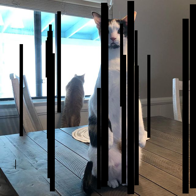

VIT: False ['shoji', 'sliding_door', 'pole', 'chime, bell, gong', 'window_screen']
BIT: False ['sliding_door', 'West_Highland_white_terrier', 'window_screen', 'shoji', 'pole']


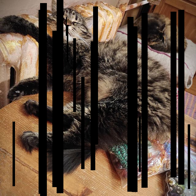

VIT: True ['tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'Persian_cat', 'pole']
BIT: False ['sliding_door', 'shoji', 'prison, prison_house', 'bannister, banister, balustrade, balusters, handrail', 'fire_screen, fireguard']


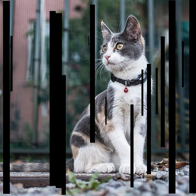

VIT: True ['worm_fence, snake_fence, snake-rail_fence, Virginia_fence', 'Egyptian_cat', 'chime, bell, gong', 'tabby, tabby_cat', 'tiger_cat']
BIT: True ['Egyptian_cat', 'sliding_door', 'window_screen', 'tabby, tabby_cat', 'tiger_cat']


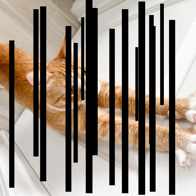

VIT: True ['tiger_cat', 'tabby, tabby_cat', 'Egyptian_cat', 'space_heater', 'radiator']
BIT: True ['bannister, banister, balustrade, balusters, handrail', 'tiger_cat', 'crib, cot', 'coil, spiral, volute, whorl, helix', 'tabby, tabby_cat']


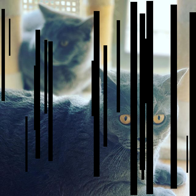

VIT: True ['chime, bell, gong', 'Egyptian_cat', 'pole', 'panpipe, pandean_pipe, syrinx', 'shoji']
BIT: True ['Egyptian_cat', 'prison, prison_house', 'tiger_cat', 'cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor', 'sliding_door']


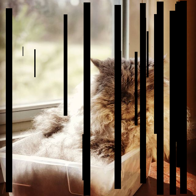

VIT: True ['Persian_cat', 'window_screen', 'pole', 'tabby, tabby_cat', 'window_shade']
BIT: False ['Airedale, Airedale_terrier', 'Norwich_terrier', 'sliding_door', 'prison, prison_house', 'window_screen']
VIT: 27; BIT: 16
Counter({'chime, bell, gong': 2, 'toy_poodle': 1, 'shoji': 1, 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence': 1})
Counter({'prison, prison_house': 7, 'bannister, banister, balustrade, balusters, handrail': 3, 'pole': 3, 'sliding_door': 2, 'Airedale, Airedale_terrier': 1})


In [19]:
test_masking(
    BlackBoxMasking(layout=FixedRatioLayout(count=20, ratio=1/30)),
    32
)

## <font color=red>!!! Stripes strongly mislead BIT models</font>

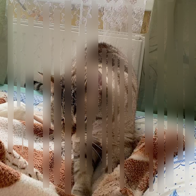

VIT: True ['crib, cot', 'radiator', 'shower_curtain', 'Egyptian_cat', 'cradle']
BIT: True ['window_shade', 'radiator', 'tiger_cat', 'crib, cot', 'space_heater']


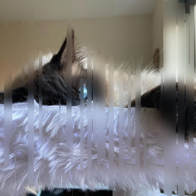

VIT: True ['radiator', 'feather_boa, boa', 'window_shade', 'space_heater', 'Siamese_cat, Siamese']
BIT: True ['bannister, banister, balustrade, balusters, handrail', 'window_shade', 'Siamese_cat, Siamese', 'window_screen', 'feather_boa, boa']


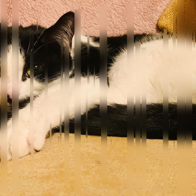

VIT: True ['radiator', 'space_heater', 'Egyptian_cat', 'tabby, tabby_cat', 'window_shade']
BIT: False ['picket_fence, paling', 'radiator', 'crib, cot', 'window_shade', 'prison, prison_house']


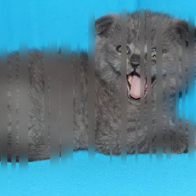

VIT: True ['chow, chow_chow', 'Persian_cat', 'keeshond', 'Pomeranian', 'Samoyed, Samoyede']
BIT: True ['Arctic_fox, white_fox, Alopex_lagopus', 'Persian_cat', 'grey_fox, gray_fox, Urocyon_cinereoargenteus', 'keeshond', 'lynx, catamount']


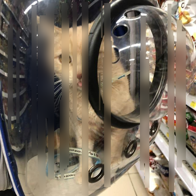

VIT: True ['solar_dish, solar_collector, solar_furnace', 'Egyptian_cat', 'Persian_cat', 'space_heater', 'tabby, tabby_cat']
BIT: False ['electric_fan, blower', 'oil_filter', 'plate_rack', 'toyshop', 'vending_machine']


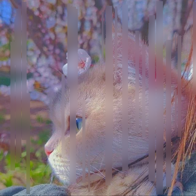

VIT: True ['Persian_cat', 'Siamese_cat, Siamese', 'Egyptian_cat', 'tabby, tabby_cat', 'lynx, catamount']
BIT: False ['bannister, banister, balustrade, balusters, handrail', 'picket_fence, paling', 'candle, taper, wax_light', 'crib, cot', 'prison, prison_house']


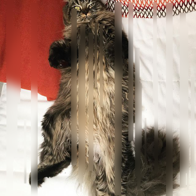

VIT: True ['tabby, tabby_cat', 'Persian_cat', 'Egyptian_cat', 'tiger_cat', 'shower_curtain']
BIT: True ['fur_coat', 'tabby, tabby_cat', 'Persian_cat', 'theater_curtain, theatre_curtain', 'window_shade']


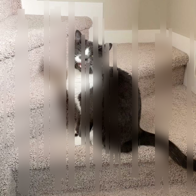

VIT: True ['radiator', 'Egyptian_cat', 'space_heater', 'shower_curtain', "plunger, plumber's_helper"]
BIT: True ['Siamese_cat, Siamese', 'sliding_door', 'wardrobe, closet, press', 'shoji', 'Arctic_fox, white_fox, Alopex_lagopus']


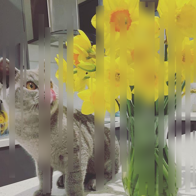

VIT: True ['shower_curtain', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'window_shade']
BIT: True ['picket_fence, paling', 'Egyptian_cat', 'candle, taper, wax_light', 'tabby, tabby_cat', 'tiger_cat']


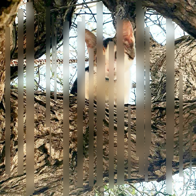

VIT: True ['Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence', 'Siamese_cat, Siamese']
BIT: True ['picket_fence, paling', 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence', 'candle, taper, wax_light', 'macaque', 'Egyptian_cat']


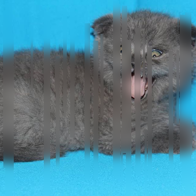

VIT: True ['Persian_cat', 'Egyptian_cat', 'lynx, catamount', 'tabby, tabby_cat', 'tiger_cat']
BIT: True ['Arctic_fox, white_fox, Alopex_lagopus', 'keeshond', 'spotlight, spot', 'Persian_cat', 'timber_wolf, grey_wolf, gray_wolf, Canis_lupus']


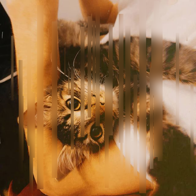

VIT: False ['butternut_squash', 'spaghetti_squash', 'acorn_squash', 'red_wine', 'space_heater']
BIT: True ['candle, taper, wax_light', 'bannister, banister, balustrade, balusters, handrail', 'tabby, tabby_cat', 'tiger_cat', 'matchstick']


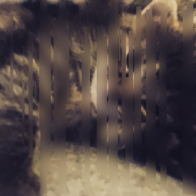

VIT: False ['radiator', 'teddy, teddy_bear', 'prison, prison_house', 'mink', 'black-footed_ferret, ferret, Mustela_nigripes']
BIT: False ['prison, prison_house', 'picket_fence, paling', 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence', 'crib, cot', 'maze, labyrinth']


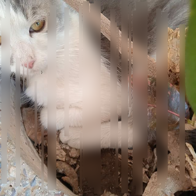

VIT: True ['Persian_cat', 'Egyptian_cat', 'Angora, Angora_rabbit', 'tabby, tabby_cat', 'tiger_cat']
BIT: True ['prison, prison_house', 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence', 'picket_fence, paling', 'crib, cot', 'Egyptian_cat']


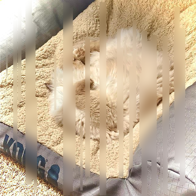

VIT: True ['toy_poodle', 'Maltese_dog, Maltese_terrier, Maltese', 'Persian_cat', 'Shih-Tzu', 'Lhasa, Lhasa_apso']
BIT: False ['crib, cot', 'West_Highland_white_terrier', 'Maltese_dog, Maltese_terrier, Maltese', 'cradle', 'cocker_spaniel, English_cocker_spaniel, cocker']


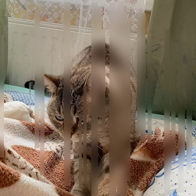

VIT: True ['Egyptian_cat', 'shower_curtain', 'tabby, tabby_cat', 'tiger_cat', 'mosquito_net']
BIT: True ['crib, cot', 'window_shade', 'prison, prison_house', 'Egyptian_cat', 'tabby, tabby_cat']


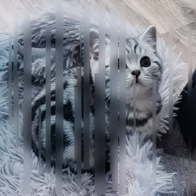

VIT: True ['radiator', 'space_heater', 'tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat']
BIT: True ['Persian_cat', 'tabby, tabby_cat', 'crib, cot', 'prison, prison_house', 'tiger_cat']


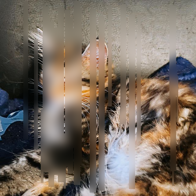

VIT: True ['tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'Persian_cat', 'tiger, Panthera_tigris']
BIT: True ['prison, prison_house', 'tiger_cat', 'tiger, Panthera_tigris', 'pole', 'window_screen']


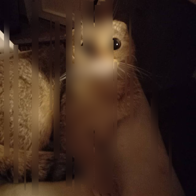

VIT: True ['polecat, fitch, foulmart, foumart, Mustela_putorius', 'weasel', 'black-footed_ferret, ferret, Mustela_nigripes', 'mink', 'Egyptian_cat']
BIT: True ['prison, prison_house', 'candle, taper, wax_light', 'spotlight, spot', 'hamster', 'Persian_cat']


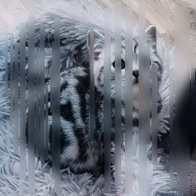

VIT: True ['tiger_cat', 'tiger, Panthera_tigris', 'snow_leopard, ounce, Panthera_uncia', 'weasel', 'tabby, tabby_cat']
BIT: False ['prison, prison_house', 'picket_fence, paling', 'radiator', 'tiger, Panthera_tigris', 'crib, cot']


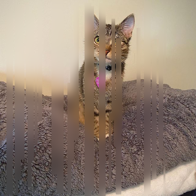

VIT: True ['Egyptian_cat', 'lynx, catamount', 'tabby, tabby_cat', 'tiger_cat', 'Siamese_cat, Siamese']
BIT: False ['grey_fox, gray_fox, Urocyon_cinereoargenteus', 'coyote, prairie_wolf, brush_wolf, Canis_latrans', 'radiator', 'window_shade', 'picket_fence, paling']


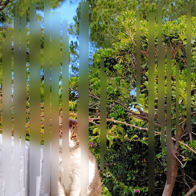

VIT: True ['Siamese_cat, Siamese', 'Egyptian_cat', 'tabby, tabby_cat', 'window_screen', 'Persian_cat']
BIT: True ['Welsh_springer_spaniel', 'window_shade', 'fountain', 'koala, koala_bear, kangaroo_bear, native_bear, Phascolarctos_cinereus', 'Siamese_cat, Siamese']
VIT: 4; BIT: -4
Counter({'radiator': 5, 'crib, cot': 1, 'chow, chow_chow': 1, 'solar_dish, solar_collector, solar_furnace': 1, 'shower_curtain': 1, 'butternut_squash': 1, 'toy_poodle': 1, 'polecat, fitch, foulmart, foumart, Mustela_putorius': 1})
Counter({'prison, prison_house': 5, 'picket_fence, paling': 3, 'bannister, banister, balustrade, balusters, handrail': 2, 'Arctic_fox, white_fox, Alopex_lagopus': 2, 'crib, cot': 2, 'window_shade': 1, 'electric_fan, blower': 1, 'fur_coat': 1, 'candle, taper, wax_light': 1, 'grey_fox, gray_fox, Urocyon_cinereoargenteus': 1, 'Welsh_springer_spaniel': 1})


In [20]:
test_masking(
    BlurMasking(layout=FixedRatioLayout(count=40, ratio=1/30)),
    16
)

## Masking 50% with GridLayout

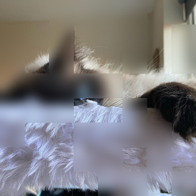

VIT: True ['Siamese_cat, Siamese', 'papillon', 'Egyptian_cat', 'Border_collie', 'skunk, polecat, wood_pussy']
BIT: False ['skunk, polecat, wood_pussy', 'affenpinscher, monkey_pinscher, monkey_dog', 'English_springer, English_springer_spaniel', 'window_shade', 'feather_boa, boa']


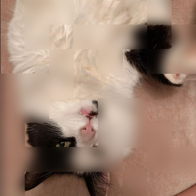

VIT: True ['Persian_cat', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'Siamese_cat, Siamese']
BIT: True ['face_powder', 'Egyptian_cat', 'Persian_cat', 'lipstick, lip_rouge', 'hair_slide']


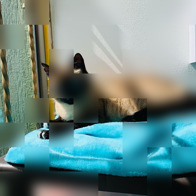

VIT: True ['Siamese_cat, Siamese', 'washbasin, handbasin, washbowl, lavabo, wash-hand_basin', 'bath_towel', 'Egyptian_cat', 'shower_curtain']
BIT: True ['shower_curtain', 'swab, swob, mop', 'Siamese_cat, Siamese', 'bath_towel', 'knot']


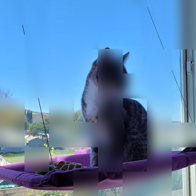

VIT: True ['tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'window_screen', 'window_shade']
BIT: True ['window_screen', 'Egyptian_cat', 'window_shade', 'tabby, tabby_cat', 'tiger_cat']


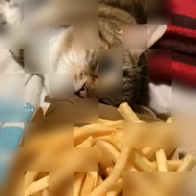

VIT: True ['tabby, tabby_cat', 'Egyptian_cat', 'tiger_cat', 'polecat, fitch, foulmart, foumart, Mustela_putorius', 'Persian_cat']
BIT: True ['knot', 'matchstick', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat']


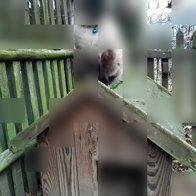

VIT: True ['Siamese_cat, Siamese', 'keeshond', 'Persian_cat', 'gibbon, Hylobates_lar', 'Pomeranian']
BIT: False ['worm_fence, snake_fence, snake-rail_fence, Virginia_fence', 'picket_fence, paling', 'park_bench', 'birdhouse', 'mink']


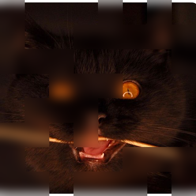

VIT: True ['matchstick', 'Persian_cat', 'Egyptian_cat', 'Siamese_cat, Siamese', 'candle, taper, wax_light']
BIT: True ['Persian_cat', 'Egyptian_cat', 'tabby, tabby_cat', 'Siamese_cat, Siamese', 'theater_curtain, theatre_curtain']
VIT: 15; BIT: 10 

Counter({'matchstick': 1})
Counter({'skunk, polecat, wood_pussy': 1, 'face_powder': 1, 'shower_curtain': 1, 'window_screen': 1, 'knot': 1, 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence': 1})


In [23]:
test_masking(
    BlurMasking(layout=GridLayout(perc=0.5, grid_size=8), blur=16),
    16
)

## Extremally Hard Tests (50%, 70%, 90%) with BlackBoxMasking

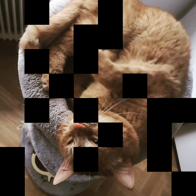

VIT: True ['radiator', 'space_heater', 'tiger_cat', 'tabby, tabby_cat', 'Egyptian_cat']
BIT: True ['Siamese_cat, Siamese', 'Egyptian_cat', 'tabby, tabby_cat', 'Persian_cat', 'cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor']


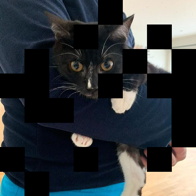

VIT: True ['sweatshirt', 'Egyptian_cat', 'tiger_cat', 'jersey, T-shirt, tee_shirt', 'tabby, tabby_cat']
BIT: True ['bulletproof_vest', 'Egyptian_cat', 'tabby, tabby_cat', 'tiger_cat', 'velvet']


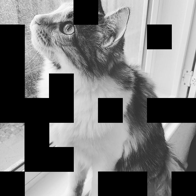

VIT: True ['cowboy_hat, ten-gallon_hat', 'Egyptian_cat', 'tabby, tabby_cat', 'bow_tie, bow-tie, bowtie', 'tiger_cat']
BIT: True ['Egyptian_cat', 'Persian_cat', 'tabby, tabby_cat', 'Siberian_husky', 'window_screen']


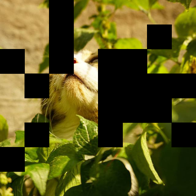

VIT: True ['bell_pepper', 'tabby, tabby_cat', 'Persian_cat', 'tiger_cat', 'Egyptian_cat']
BIT: False ['three-toed_sloth, ai, Bradypus_tridactylus', 'meerkat, mierkat', 'polecat, fitch, foulmart, foumart, Mustela_putorius', 'titi, titi_monkey', 'marmoset']


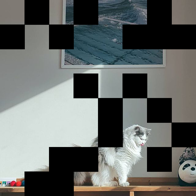

VIT: True ['Pomeranian', 'entertainment_center', 'Persian_cat', 'papillon', 'keeshond']
BIT: False ['West_Highland_white_terrier', 'television, television_system', 'Shih-Tzu', 'Old_English_sheepdog, bobtail', 'soccer_ball']


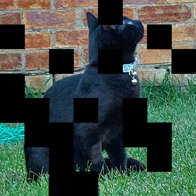

VIT: True ['schipperke', 'groenendael', 'kelpie', 'Egyptian_cat', 'flat-coated_retriever']
BIT: False ['American_black_bear, black_bear, Ursus_americanus, Euarctos_americanus', 'schipperke', 'groenendael', 'French_bulldog', 'sloth_bear, Melursus_ursinus, Ursus_ursinus']


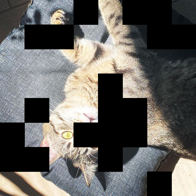

VIT: True ['jean, blue_jean, denim', 'tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'lynx, catamount']
BIT: True ['tabby, tabby_cat', 'Egyptian_cat', 'tiger_cat', 'lynx, catamount', 'jean, blue_jean, denim']
VIT: 9; BIT: 12 

Counter({'radiator': 1, 'sweatshirt': 1, 'cowboy_hat, ten-gallon_hat': 1, 'bell_pepper': 1, 'Pomeranian': 1, 'schipperke': 1, 'jean, blue_jean, denim': 1})
Counter({'bulletproof_vest': 1, 'three-toed_sloth, ai, Bradypus_tridactylus': 1, 'West_Highland_white_terrier': 1, 'American_black_bear, black_bear, Ursus_americanus, Euarctos_americanus': 1})


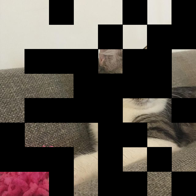

VIT: True ['crossword_puzzle, crossword', 'tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'Persian_cat']
BIT: True ['crossword_puzzle, crossword', 'maze, labyrinth', 'window_screen', 'Egyptian_cat', 'malamute, malemute, Alaskan_malamute']


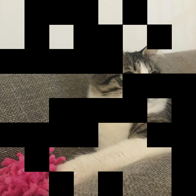

VIT: True ['crossword_puzzle, crossword', 'tabby, tabby_cat', 'tiger_cat', 'Egyptian_cat', 'swab, swob, mop']
BIT: False ['malamute, malemute, Alaskan_malamute', 'Siberian_husky', 'skunk, polecat, wood_pussy', 'Eskimo_dog, husky', 'crossword_puzzle, crossword']


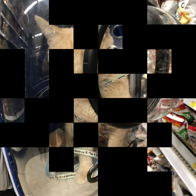

VIT: True ['gong, tam-tam', 'steel_drum', 'refrigerator, icebox', 'chime, bell, gong', 'Egyptian_cat']
BIT: True ['Egyptian_cat', 'plastic_bag', 'tabby, tabby_cat', 'web_site, website, internet_site, site', 'water_bottle']


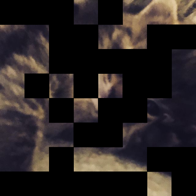

VIT: False ['crossword_puzzle, crossword', 'brown_bear, bruin, Ursus_arctos', 'gibbon, Hylobates_lar', 'sloth_bear, Melursus_ursinus, Ursus_ursinus', 'American_black_bear, black_bear, Ursus_americanus, Euarctos_americanus']
BIT: False ['maze, labyrinth', 'crossword_puzzle, crossword', 'window_screen', 'earthstar', 'nematode, nematode_worm, roundworm']
VIT: 12; BIT: 13 

Counter({'crossword_puzzle, crossword': 3, 'gong, tam-tam': 1})
Counter({'crossword_puzzle, crossword': 1, 'malamute, malemute, Alaskan_malamute': 1, 'maze, labyrinth': 1})


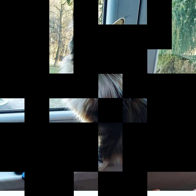

VIT: True ['Yorkshire_terrier', 'Australian_terrier', 'Persian_cat', 'window_screen', 'silky_terrier, Sydney_silky']
BIT: True ['window_screen', 'window_shade', 'sliding_door', 'monitor', 'Persian_cat']


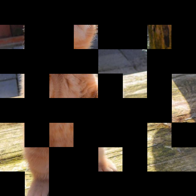

VIT: False ['dingo, warrigal, warragal, Canis_dingo', 'golden_retriever', 'cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor', 'chow, chow_chow', 'vizsla, Hungarian_pointer']
BIT: True ['window_screen', 'Pomeranian', 'doormat, welcome_mat', 'chow, chow_chow', 'Persian_cat']


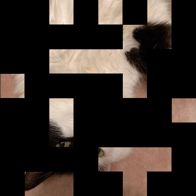

VIT: True ['Persian_cat', 'Border_collie', 'Egyptian_cat', 'collie', 'papillon']
BIT: True ['skunk, polecat, wood_pussy', 'Siberian_husky', 'Persian_cat', 'maze, labyrinth', 'malamute, malemute, Alaskan_malamute']


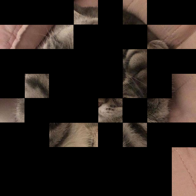

VIT: True ['tiger_cat', 'tabby, tabby_cat', 'Egyptian_cat', 'snow_leopard, ounce, Panthera_uncia', 'tiger, Panthera_tigris']
BIT: False ['Siberian_husky', 'pug, pug-dog', 'malamute, malemute, Alaskan_malamute', 'Norwegian_elkhound, elkhound', 'fur_coat']


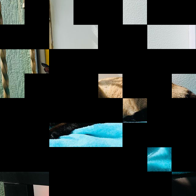

VIT: False ['malinois', 'Great_Dane', 'bull_mastiff', 'Chesapeake_Bay_retriever', 'Rhodesian_ridgeback']
BIT: False ['shoji', 'window_screen', 'malinois', 'Brabancon_griffon', 'sliding_door']


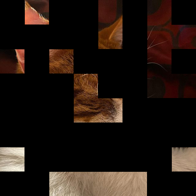

VIT: True ['dingo, warrigal, warragal, Canis_dingo', 'dhole, Cuon_alpinus', 'basenji', 'Egyptian_cat', 'Ibizan_hound, Ibizan_Podenco']
BIT: True ['Egyptian_cat', 'Border_terrier', 'Norwich_terrier', 'tiger_cat', 'coyote, prairie_wolf, brush_wolf, Canis_latrans']


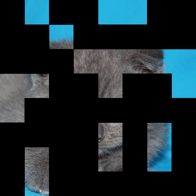

VIT: True ['Persian_cat', 'keeshond', 'macaque', 'Egyptian_cat', 'tabby, tabby_cat']
BIT: True ['window_screen', 'maze, labyrinth', 'Egyptian_cat', 'monitor', 'cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor']


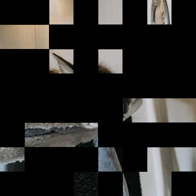

VIT: False ['washer, automatic_washer, washing_machine', 'bannister, banister, balustrade, balusters, handrail', 'bathtub, bathing_tub, bath, tub', 'washbasin, handbasin, washbowl, lavabo, wash-hand_basin', 'iron, smoothing_iron']
BIT: False ['shoji', 'window_screen', 'maze, labyrinth', 'prison, prison_house', 'mask']


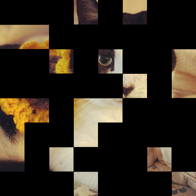

VIT: True ['Chihuahua', 'Boston_bull, Boston_terrier', 'Siamese_cat, Siamese', 'toy_terrier', 'basenji']
BIT: True ['window_screen', 'Egyptian_cat', 'maze, labyrinth', 'tabby, tabby_cat', 'tiger_cat']


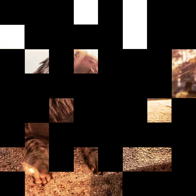

VIT: False ['hog, pig, grunter, squealer, Sus_scrofa', 'wild_boar, boar, Sus_scrofa', 'mongoose', 'zebra', 'warthog']
BIT: False ['maze, labyrinth', 'web_site, website, internet_site, site', 'wombat', 'skunk, polecat, wood_pussy', 'picket_fence, paling']


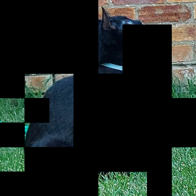

VIT: True ['schipperke', 'kelpie', 'Doberman, Doberman_pinscher', 'Egyptian_cat', 'miniature_pinscher']
BIT: False ['American_black_bear, black_bear, Ursus_americanus, Euarctos_americanus', 'wombat', 'sloth_bear, Melursus_ursinus, Ursus_ursinus', 'chimpanzee, chimp, Pan_troglodytes', 'groenendael']


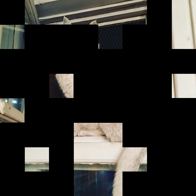

VIT: False ['window_screen', 'window_shade', 'bannister, banister, balustrade, balusters, handrail', 'hook, claw', 'prison, prison_house']
BIT: False ['window_screen', 'window_shade', 'shoji', 'sliding_door', 'envelope']
VIT: 7; BIT: 5 

Counter({'dingo, warrigal, warragal, Canis_dingo': 2, 'Yorkshire_terrier': 1, 'malinois': 1, 'washer, automatic_washer, washing_machine': 1, 'Chihuahua': 1, 'hog, pig, grunter, squealer, Sus_scrofa': 1, 'schipperke': 1, 'window_screen': 1})
Counter({'window_screen': 5, 'shoji': 2, 'skunk, polecat, wood_pussy': 1, 'Siberian_husky': 1, 'maze, labyrinth': 1, 'American_black_bear, black_bear, Ursus_americanus, Euarctos_americanus': 1})


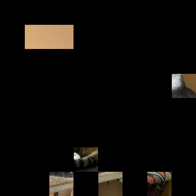

VIT: True ['Egyptian_cat', 'tabby, tabby_cat', 'Siamese_cat, Siamese', 'mousetrap', 'bolo_tie, bolo, bola_tie, bola']
BIT: False ['Band_Aid', 'Greater_Swiss_Mountain_dog', 'prison, prison_house', 'EntleBucher', 'guenon, guenon_monkey']


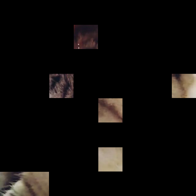

VIT: True ['tiger_cat', 'tiger, Panthera_tigris', 'Egyptian_cat', 'tabby, tabby_cat', 'snow_leopard, ounce, Panthera_uncia']
BIT: False ['web_site, website, internet_site, site', 'window_screen', 'television, television_system', 'spotlight, spot', 'cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor']


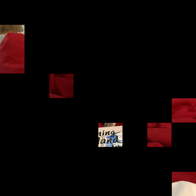

VIT: False ['theater_curtain, theatre_curtain', 'velvet', 'studio_couch, day_bed', 'cinema, movie_theater, movie_theatre, movie_house, picture_palace', 'home_theater, home_theatre']
BIT: False ['envelope', 'quilt, comforter, comfort, puff', 'packet', 'web_site, website, internet_site, site', 'pillow']


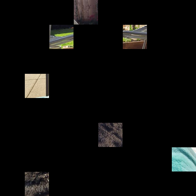

VIT: False ['ashcan, trash_can, garbage_can, wastebin, ash_bin, ash-bin, ashbin, dustbin, trash_barrel, trash_bin', 'pole', 'sliding_door', 'barrel, cask', 'milk_can']
BIT: False ['window_screen', 'window_shade', 'envelope', 'monitor', 'sliding_door']


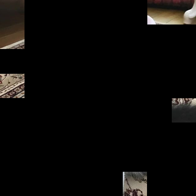

VIT: False ['table_lamp', 'lampshade, lamp_shade', 'gown', 'television, television_system', 'shoji']
BIT: False ['television, television_system', 'window_screen', 'web_site, website, internet_site, site', 'window_shade', 'home_theater, home_theatre']


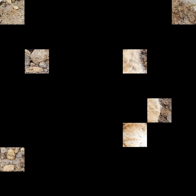

VIT: True ['cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor', 'sidewinder, horned_rattlesnake, Crotalus_cerastes', 'tiger, Panthera_tigris', 'Egyptian_cat', 'diamondback, diamondback_rattlesnake, Crotalus_adamanteus']
BIT: False ['maze, labyrinth', 'stone_wall', 'window_screen', 'megalith, megalithic_structure', 'window_shade']


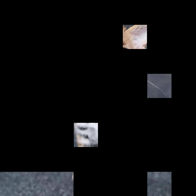

VIT: False ['pug, pug-dog', 'Chihuahua', 'mousetrap', 'tennis_ball', 'Norwich_terrier']
BIT: False ['envelope', 'web_site, website, internet_site, site', 'spotlight, spot', 'book_jacket, dust_cover, dust_jacket, dust_wrapper', 'monitor']


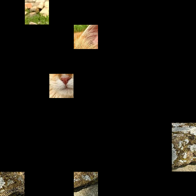

VIT: False ['stone_wall', 'hog, pig, grunter, squealer, Sus_scrofa', 'worm_fence, snake_fence, snake-rail_fence, Virginia_fence', 'hen', 'cock']
BIT: False ['stone_wall', 'guinea_pig, Cavia_cobaya', 'megalith, megalithic_structure', 'window_shade', 'wombat']


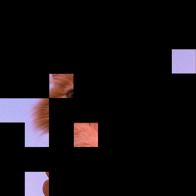

VIT: False ['gibbon, Hylobates_lar', 'macaque', 'langur', 'proboscis_monkey, Nasalis_larvatus', 'baboon']
BIT: False ['spotlight, spot', 'Pomeranian', 'window_screen', 'mask', 'window_shade']


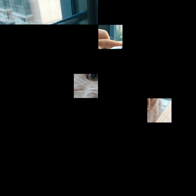

VIT: True ['window_screen', 'window_shade', 'prison, prison_house', 'shoji', 'Egyptian_cat']
BIT: True ['window_screen', 'window_shade', 'monitor', 'Egyptian_cat', 'television, television_system']


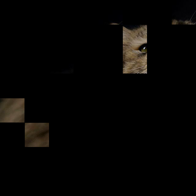

VIT: False ['wombat', 'polecat, fitch, foulmart, foumart, Mustela_putorius', 'mink', 'weasel', 'black-footed_ferret, ferret, Mustela_nigripes']
BIT: False ['cheetah, chetah, Acinonyx_jubatus', 'timber_wolf, grey_wolf, gray_wolf, Canis_lupus', 'coyote, prairie_wolf, brush_wolf, Canis_latrans', 'cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor', 'lion, king_of_beasts, Panthera_leo']


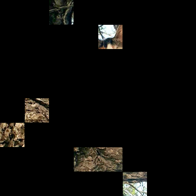

VIT: False ['guillotine', 'birdhouse', 'thatch, thatched_roof', 'lampshade, lamp_shade', 'chime, bell, gong']
BIT: False ['window_screen', 'maze, labyrinth', 'jigsaw_puzzle', 'window_shade', 'stone_wall']


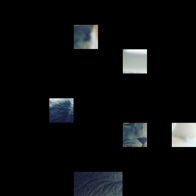

VIT: False ['web_site, website, internet_site, site', 'window_shade', 'window_screen', 'shoji', 'analog_clock']
BIT: False ['window_screen', 'shoji', 'window_shade', 'spotlight, spot', 'sliding_door']


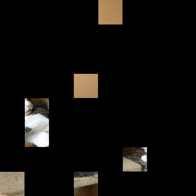

VIT: True ['Egyptian_cat', 'shoji', 'Siamese_cat, Siamese', 'Brabancon_griffon', 'Chihuahua']
BIT: False ['window_screen', 'shoji', 'window_shade', 'sliding_door', 'Band_Aid']


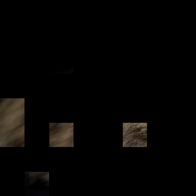

VIT: False ['black-footed_ferret, ferret, Mustela_nigripes', 'polecat, fitch, foulmart, foumart, Mustela_putorius', 'macaque', 'chimpanzee, chimp, Pan_troglodytes', 'badger']
BIT: False ['window_screen', 'maze, labyrinth', 'shoji', 'guillotine', 'prison, prison_house']


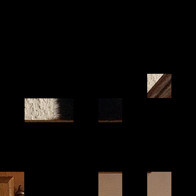

VIT: True ['Egyptian_cat', 'shoji', 'Siamese_cat, Siamese', 'Samoyed, Samoyede', 'Eskimo_dog, husky']
BIT: False ['shoji', 'sliding_door', 'window_screen', 'picket_fence, paling', 'window_shade']
VIT: 4; BIT: 0 

Counter({'theater_curtain, theatre_curtain': 1, 'ashcan, trash_can, garbage_can, wastebin, ash_bin, ash-bin, ashbin, dustbin, trash_barrel, trash_bin': 1, 'table_lamp': 1, 'cougar, puma, catamount, mountain_lion, painter, panther, Felis_concolor': 1, 'pug, pug-dog': 1, 'stone_wall': 1, 'gibbon, Hylobates_lar': 1, 'window_screen': 1, 'wombat': 1, 'guillotine': 1, 'web_site, website, internet_site, site': 1, 'black-footed_ferret, ferret, Mustela_nigripes': 1})
Counter({'window_screen': 6, 'envelope': 2, 'Band_Aid': 1, 'web_site, website, internet_site, site': 1, 'television, television_system': 1, 'maze, labyrinth': 1, 'stone_wall': 1, 'spotlight, spot': 1, 'cheetah, chetah, Acinonyx_jubatus': 1, 'shoji': 1})


In [28]:
for perc in (0.3, 0.5, 0.7, 0.9):
    test_masking(
        BlackBoxMasking(layout=GridLayout(perc=perc, grid_size=8)),
        16
    )

# Test summary

In [90]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)

df = pd.DataFrame([
    ["BlackBoxMasking(layout=FixedShapeLayout(count=3, shape=(128, 128)))", 29, 29, 32],
    ["BlurMasking(layout=FixedShapeLayout(count=5, shape=(128, 128)))", 29, 29, 32],
    ["BlackBoxMasking(layout=FixedRatioLayout(count=20, ratio=1/30))", 27, 16, 32],
    ["BlurMasking(layout=FixedRatioLayout(count=40, ratio=1/30))", 20, 12, 32],
    ["BlurMasking(layout=GridLayout(perc=0.5, grid_size=8), blur=16)", 15, 10, 16],
    ["BlackBoxMasking(layout=GridLayout(perc=0.3, grid_size=8))", 9, 12, 16],
    ["BlackBoxMasking(layout=GridLayout(perc=0.5, grid_size=8))", 12, 13, 16],
    ["BlackBoxMasking(layout=GridLayout(perc=0.7, grid_size=8))", 7, 5, 16],
    ["BlackBoxMasking(layout=GridLayout(perc=0.9, grid_size=8))", 4, 0, 16],
], columns=['test-name', 'vit-score', 'bit-score', 'case-count'])

display(df)

print("VIT: %.2f%%" % (100.0*df['vit-score'].sum() / df['case-count'].sum()))
print("BIT: %.2f%%" % (100.0*df['bit-score'].sum() / df['case-count'].sum()))

test-name  \
0  BlackBoxMasking(layout=FixedShapeLayout(count=3, shape=(128, 128)))   
1      BlurMasking(layout=FixedShapeLayout(count=5, shape=(128, 128)))   
2       BlackBoxMasking(layout=FixedRatioLayout(count=20, ratio=1/30))   
3           BlurMasking(layout=FixedRatioLayout(count=40, ratio=1/30))   
4       BlurMasking(layout=GridLayout(perc=0.5, grid_size=8), blur=16)   
5            BlackBoxMasking(layout=GridLayout(perc=0.3, grid_size=8))   
6            BlackBoxMasking(layout=GridLayout(perc=0.5, grid_size=8))   
7            BlackBoxMasking(layout=GridLayout(perc=0.7, grid_size=8))   
8            BlackBoxMasking(layout=GridLayout(perc=0.9, grid_size=8))   

   vit-score  bit-score  case-count  
0         29         29          32  
1         29         29          32  
2         27         16          32  
3         20         12          32  
4         15         10          16  
5          9         12          16  
6         12         13          16  
7          7          5          16  
8          4          0          16

VIT: 73.08%
BIT: 60.58%


# Check which image fragment is important for classification

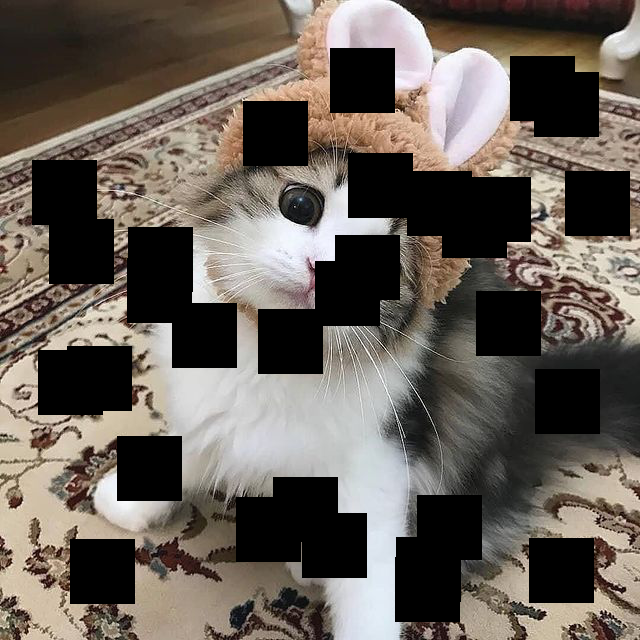

In [94]:
mask = BlackBoxMasking(layout=FixedShapeLayout(count=30, shape=(64, 64)))

img = images[15]
display(mask(img))

In [ ]:
from tqdm import tqdm

vit_heatmap = np.zeros((640, 640), dtype=int)
bit_heatmap = np.zeros((640, 640), dtype=int)
vit_count = bit_count = 0

total = 300

for _ in tqdm(range(total)):
    tmp = mask(img)
    a = np.array(tmp)
    x = (a[:,:,0] == 0) & (a[:,:,1] == 0) & (a[:,:,2] == 0)
    if not is_cat(predict(VIT, [tmp])[0]):
        vit_heatmap += x
        vit_count += 1
    if not is_cat(predict(BIT, [tmp])[0]):
        bit_heatmap += x
        bit_count += 1

  0%|          | 0/300 [00:00<?, ?it/s]

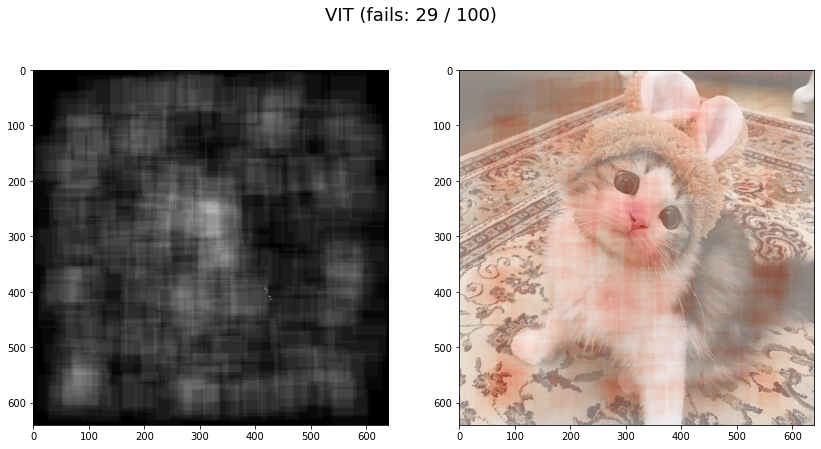

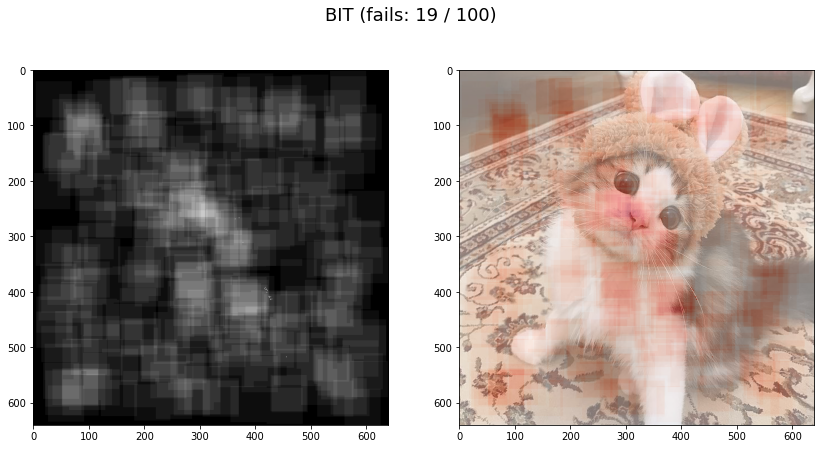

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(vit_heatmap, cmap='gray')
axs[1].imshow(img)
axs[1].imshow(vit_heatmap, cmap='Reds', alpha=0.5)
fig.suptitle(f"VIT (fails: {vit_count} / {total})", size=18)
plt.show()

##########
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(bit_heatmap, cmap='gray')

axs[1].imshow(img)
axs[1].imshow(bit_heatmap, cmap='Reds', alpha=0.5)
fig.suptitle(f"BIT (fails: {bit_count} / {total})", size=18)
plt.show()

# Use Lime?
https://github.com/marcotcr/lime